In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('WAG_C_M.csv', parse_dates=['month'], sep=';', index_col='month', dayfirst=True)

<Figure size 1080x504 with 0 Axes>

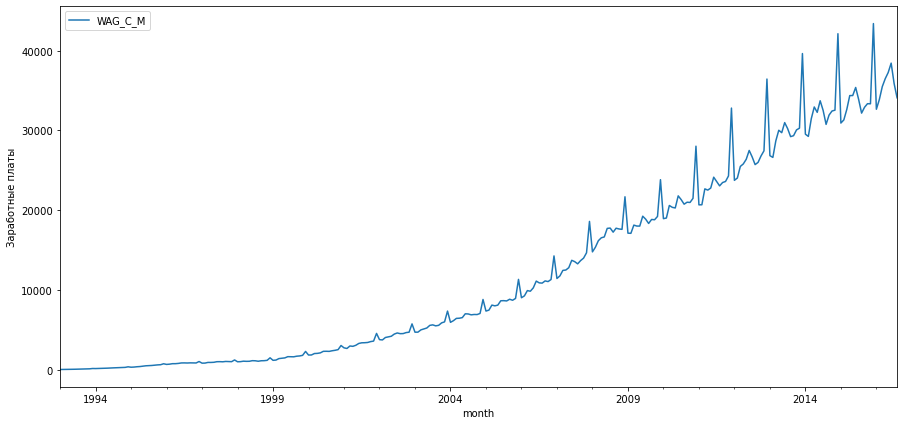

In [3]:
plt.figure(figsize(15,7))
df.plot()
plt.ylabel('Заработные платы')
pylab.show()

Ряд имеет возрастающий тренд с выраженной сезонностью и увеличивающейся дисперсией.
Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.813411


<Figure size 1080x720 with 0 Axes>

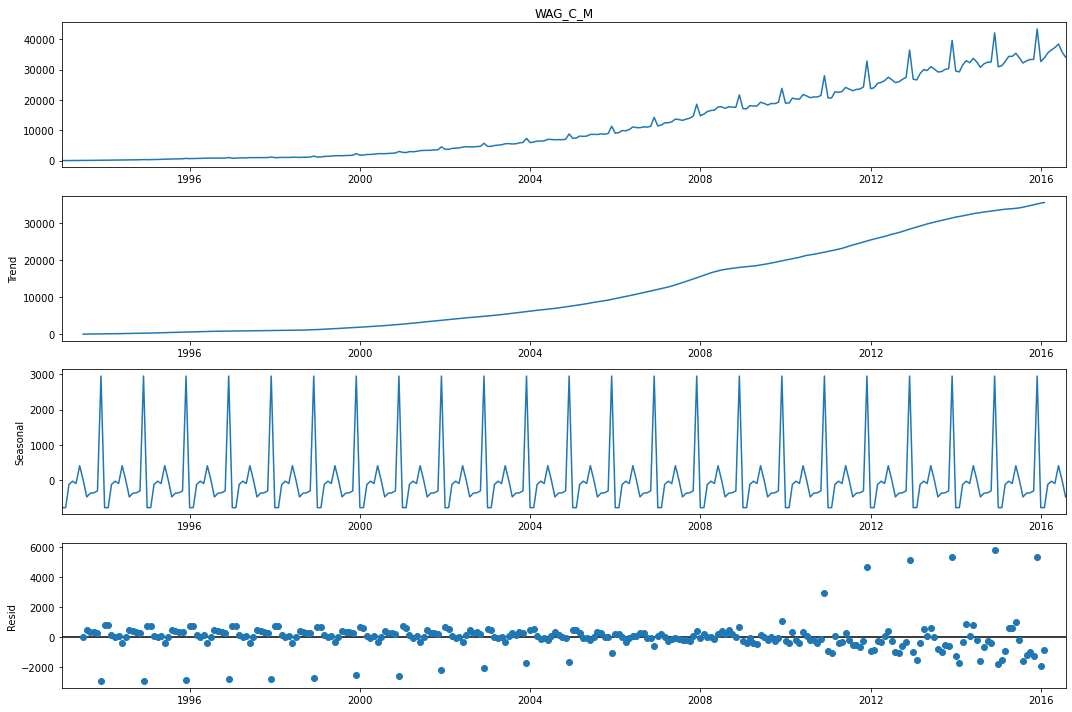

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[0])

## Стабилизация дисперсии


Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


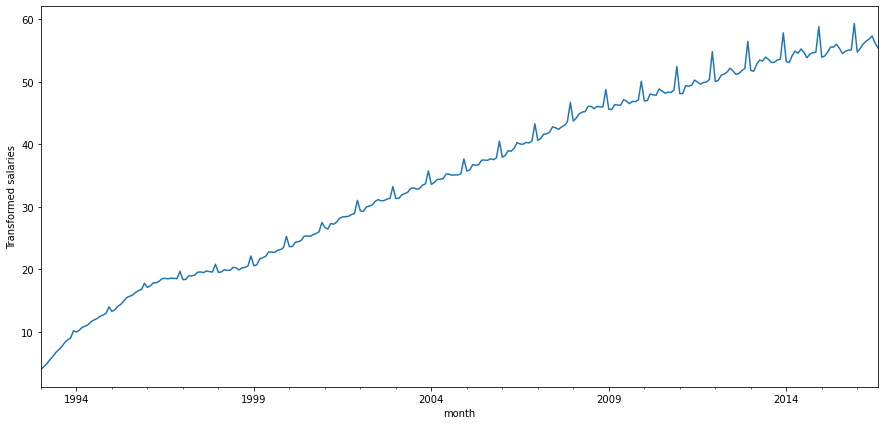

In [5]:
df['salary_box'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df['salary_box'].plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box)[1])

### Стационарность


Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

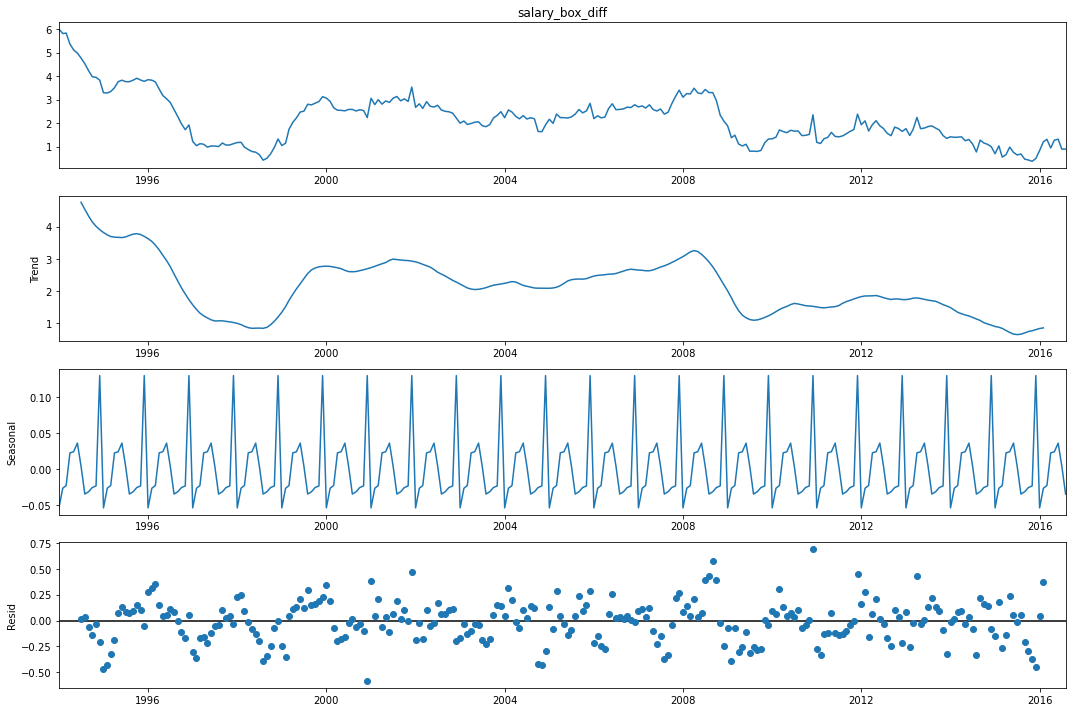

In [6]:
df['salary_box_diff'] = df['salary_box'] - df['salary_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['salary_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['salary_box_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

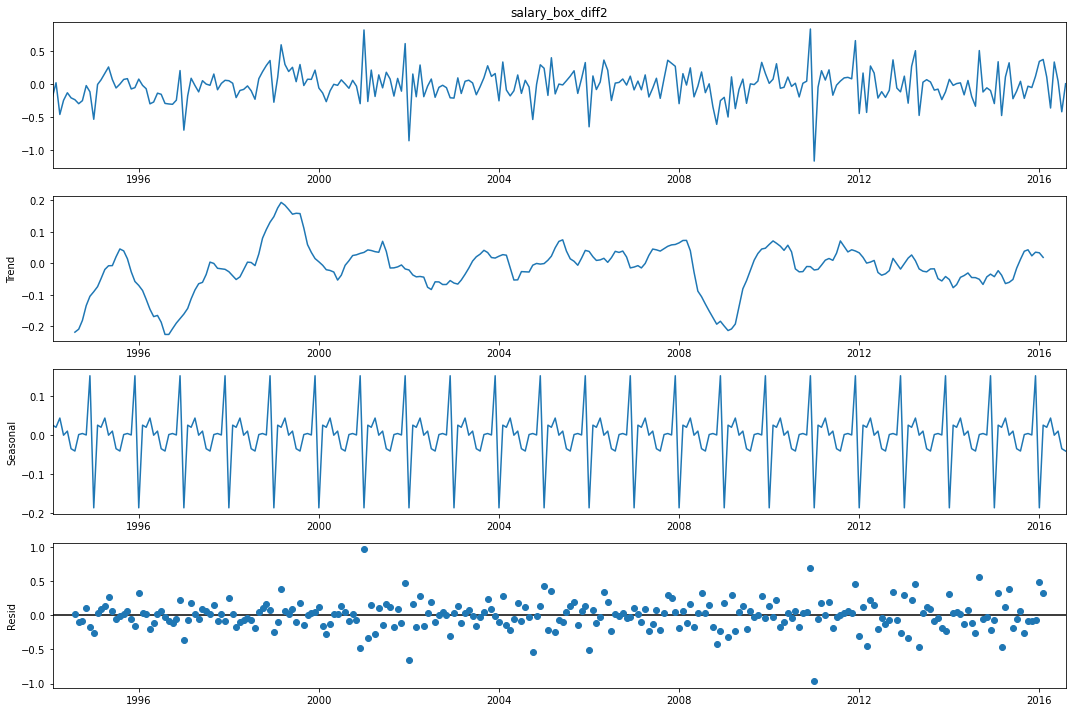

In [7]:
df['salary_box_diff2'] = df['salary_box_diff'] - df['salary_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['salary_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['salary_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

### Подбор модели


Посмотрим на ACF и PACF полученного ряда:

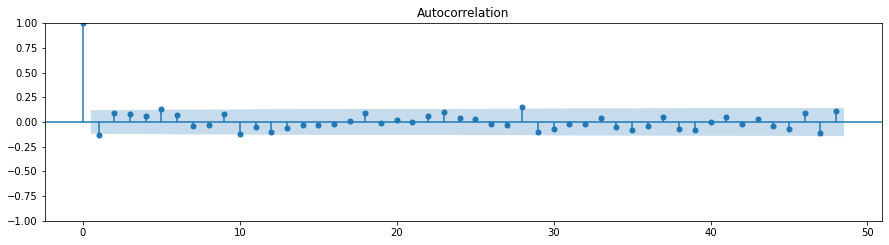

/Users/dashakaravaieva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


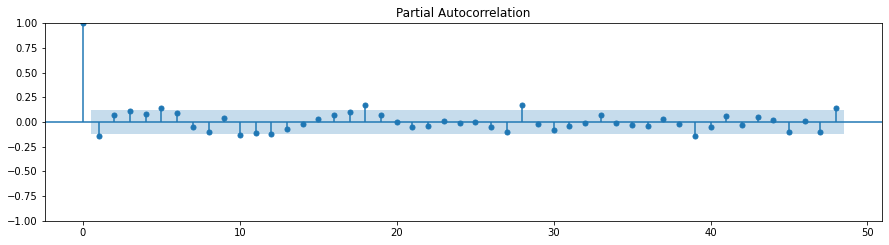

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['salary_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['salary_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=5, P=4, p=10

In [28]:
ps = range(0, 6)
d=1
qs = range(0, 4)
Ps = range(0, 3)
D=1
Qs = range(0, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

216

In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['salary_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 9min 59s, sys: 9min 41s, total: 19min 40s
Wall time: 7min 17s


In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
131  (3, 2, 1, 2) -22.934091
167  (4, 2, 1, 2) -22.788483
104  (2, 3, 1, 2) -22.782602
107  (2, 3, 2, 2) -21.799635
134  (3, 2, 2, 2) -21.561229


In [31]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood                  20.467
Date:                            Wed, 27 Apr 2022   AIC                            -22.934
Time:                                    19:12:24   BIC                              9.485
Sample:                                01-01-1993   HQIC                            -9.917
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4591      0.056     25.973      0.000       1.349       1.569
ar.L2         -0.6121      0.096   

Критерий Стьюдента: p=0.409839
Критерий Дики-Фуллера: p=0.000000


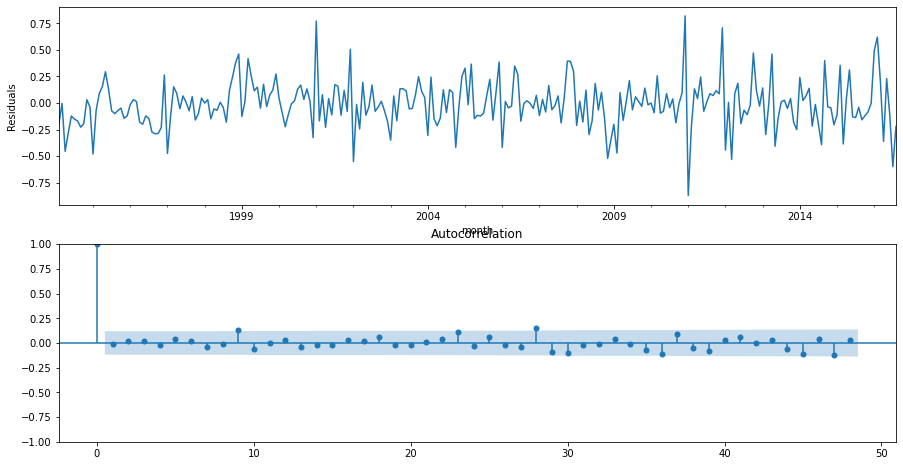

In [32]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:



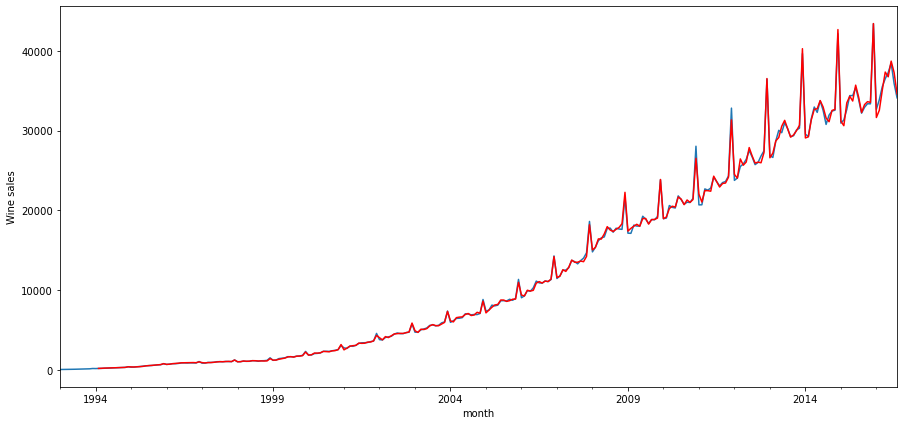

In [33]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['WAG_C_M'].plot()
df['model'][13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

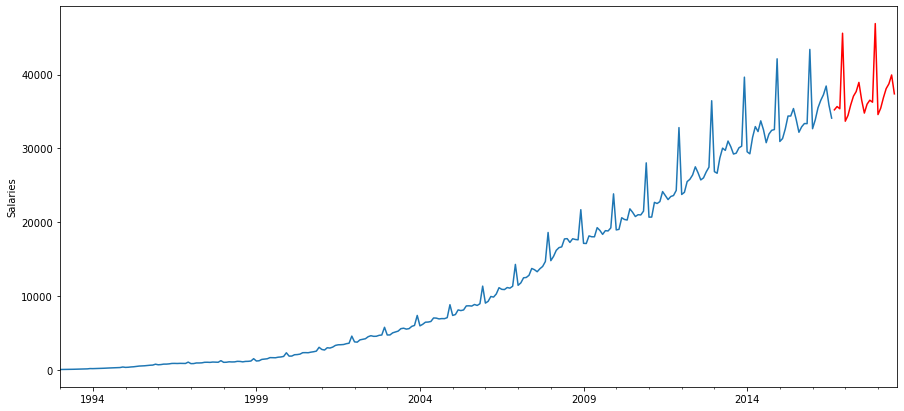

In [34]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=306), lmbda)

plt.figure(figsize(15,7))
df2['WAG_C_M'].plot()
df2['forecast'].plot(color='r')
plt.ylabel('Salaries')
pylab.show()

In [20]:
df.shape

(284, 5)

In [21]:
df

,WAG_C_M,salary_box,salary_box_diff,salary_box_diff2,model
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,NaN,15.300000
1993-03-01,23.6,4.931635,NaN,NaN,19.100000
1993-04-01,30.6,5.549430,NaN,NaN,23.600000
1993-05-01,37.5,6.063406,NaN,NaN,30.600000
...,...,...,...,...,...
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37250.933086
2016-05-01,37270.0,56.860441,1.275065,0.332336,36899.046032
2016-06-01,38447.0,57.358885,1.316994,0.041929,38744.962773
